# Graph My Task Statistics

We'll use the matplotlib [Stacked Area Plot](https://www.python-graph-gallery.com/stacked-area-plot/) to visualize the accumulation of incoming vs. completed tasks over time.

In [31]:
%matplotlib widget

import math
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
import mplcursors

from main import AmazingCloudAntClient

client = AmazingCloudAntClient()

# Get tasks since...
since = dt.datetime(2023, 7, 1).timestamp() * 1000
chart_data = client.get_task_stats_for_chart(since=since)

date_fmt = DateFormatter("%Y-%m-%d")

Avg New Tasks per Day: 2.909090909090909
Avg Completed Tasks per Day: 4.045454545454546
Avg Backlog Increase: -1.1363636363636365


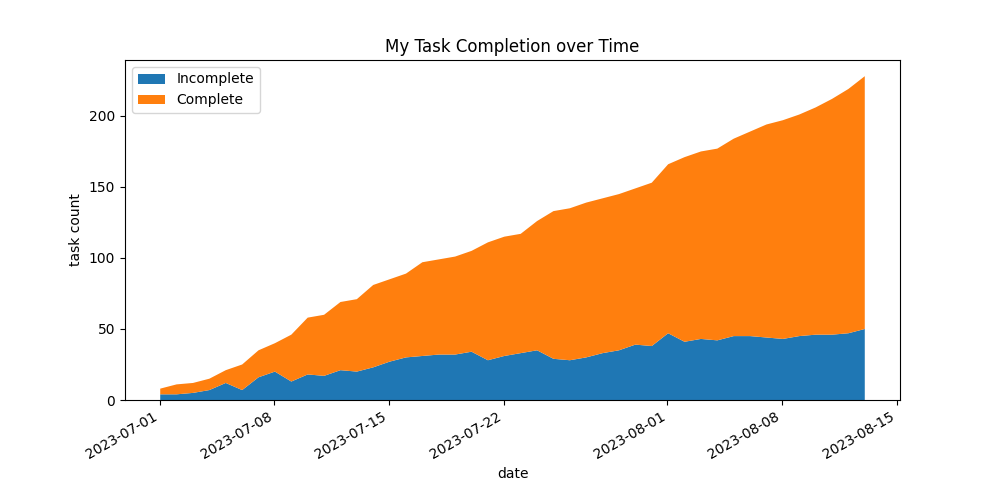

In [32]:
%matplotlib widget
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

# Set up figure
ax.stackplot(
    chart_data["dates"],
    chart_data["incomplete"],
    chart_data["complete"],
    labels=['Incomplete','Complete'],
)
plt.legend(loc='upper left')
plt.title("My Task Completion over Time")
plt.xlabel('date')
plt.ylabel('task count')

# Format Dates
fig.autofmt_xdate()
ax.xaxis.set_major_formatter(date_fmt)

mplcursors.cursor(hover=True)

# Quick Stats
cpd = chart_data["complete"][-1] / len(chart_data["dates"])
ipd = (chart_data["incomplete"][-1] - 100) / len(chart_data["dates"])
print("Avg New Tasks per Day:", cpd+ipd)
print("Avg Completed Tasks per Day:", cpd)
print("Avg Backlog Increase:", ipd)

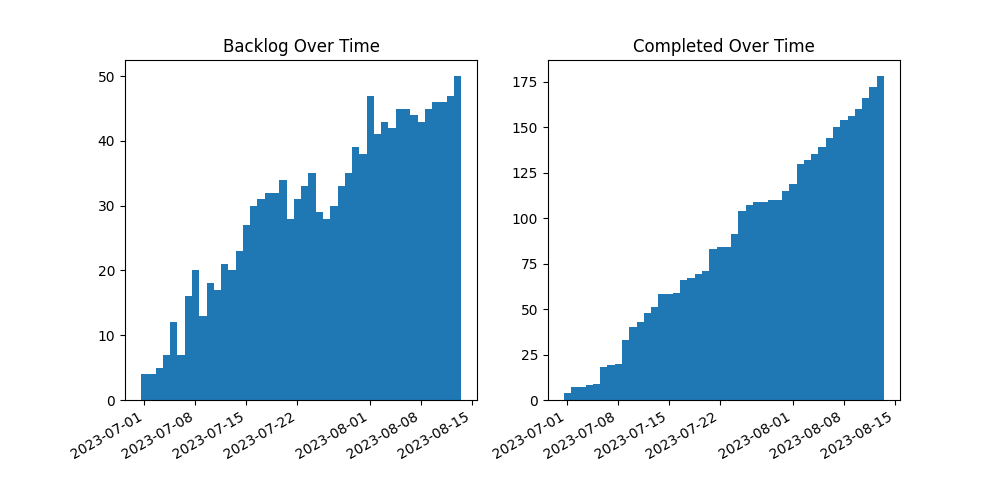

In [33]:
# Set up figures
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(10, 5))
ax1.title.set_text("Backlog Over Time")
ax2.title.set_text("Completed Over Time")
ax1.bar(chart_data["dates"], chart_data["incomplete"], width=1)
ax2.bar(chart_data["dates"], chart_data["complete"], width=1)

# Format dates
fig.autofmt_xdate()
date_form = DateFormatter("%Y-%m-%d")
ax1.xaxis.set_major_formatter(date_form)
ax2.xaxis.set_major_formatter(date_form)

# mplcursors.cursor(hover=True)

In [34]:
# Tasks Added / Removed Today
today = dt.datetime.now()
week_ago = today - dt.timedelta(days=7)
today_stats = client.get_tasks_added_removed_between(start=week_ago, end=today)

print("THIS WEEK'S TASK STATS")

print(f'{ len(today_stats["created"]) } Task/s Created')
for t in today_stats["created"][:5]:
    print(f'  - { t["doc"]["title"] }')

print('')

print(f'{ len(today_stats["completed"]) } Task/s Completed')
for t in today_stats["completed"][:5]:
    print(f'  - { t["doc"]["title"] }')

THIS WEEK'S TASK STATS
37 Task/s Created
  - Weekly Reminder: Check in on Mikael feedback - https://docs.google.com/document/d/1IsDx95KhuxhFXoGtF1jt8sz2L8GuZ2_hWqfYSMLquds/edit#heading=h.l6mv1kvmjclz
  - (Monthly) Pay PNC card
  - Jury Duty - Call after 5pm: 202-354-3518 | 103895809
  - Weekly Review
  - Reminder: Audio Recording > Audio Journal > 2021

33 Task/s Completed
  - Mighty Brother: Update QBO Transactions
  - Review and think about our financial projections on my own [Slack Msg from Neil Shah](https://thinknimble.slack.com/archives/CNYHCPHRV/p1650463258685949)
  - Weekly Reminder: Check in on Mikael feedback - https://docs.google.com/document/d/1IsDx95KhuxhFXoGtF1jt8sz2L8GuZ2_hWqfYSMLquds/edit#heading=h.l6mv1kvmjclz
  - (Monthly) Pay PNC card
  - Jury Duty - Call after 5pm: 202-354-3518 | 103895809


NOTE: Negative cycle times are recurring tasks that were marked 'done' before the date of recurrence.

Q1: 0.2343873726851852
Q3: 4.276500237268518
IQR: 4.042112864583333
outer_fence: 16.402838831018517
95th: 44.40860680324051
99th: 257.3636791453704

334 outliers of 3255: [16.49248732638889, 16.520068842592593, 16.581976875] ... [451.4066702777778, 523.7625834027778, 556.1934447916667]


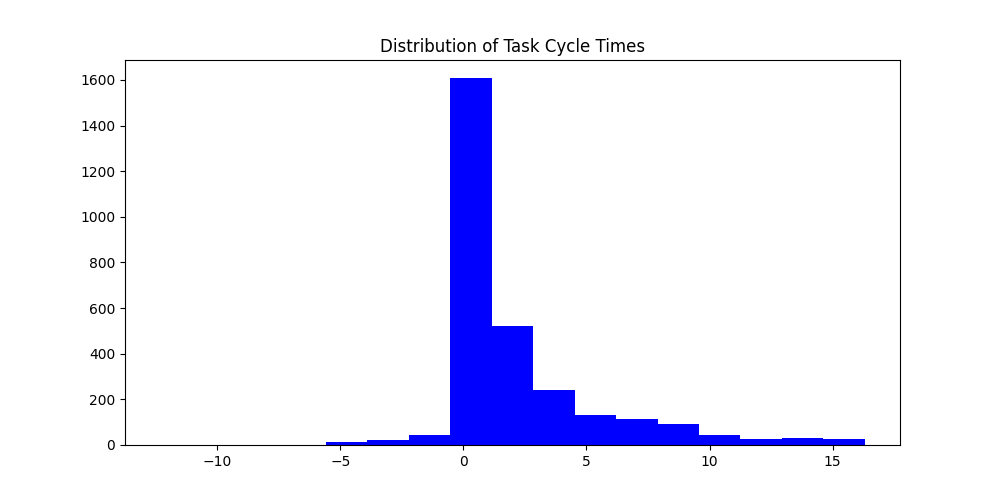

In [35]:
# Look at distribution of task cycle times
tasks = client.get_all_tasks()
cycle_times = sorted([t.cycle_time for t in tasks if t.done])

q1, q3, n5, n9 = np.percentile(cycle_times, [25, 75, 95, 99])
iqr = q3 - q1
outer_fence = q3 + 3*(iqr)

print("NOTE: Negative cycle times are recurring tasks that were marked 'done' before the date of recurrence.")

print(f"""
Q1: {q1}
Q3: {q3}
IQR: {iqr}
outer_fence: {outer_fence}
95th: {n5}
99th: {n9}
""")

outliers = sorted([c for c in cycle_times if c >= outer_fence])
print(f"{len(outliers)} outliers of {len(cycle_times)}: {outliers[:3]} ... {outliers[-3:]}")

# Filter out outliers
a = [i for i in cycle_times if i not in outliers]

# Plot it
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.hist(a, bins=math.ceil(max(a)), histtype ='bar', facecolor='blue')
ax.title.set_text("Distribution of Task Cycle Times")


NOTE: Negative cycle times are recurring tasks that were marked 'done' before the date of recurrence.

Q1: 0.44605602141203704
Q3: 6.557058781828704
IQR: 6.111002760416667
outer_fence: 24.890067063078703
95th: 68.26541648206012
99th: 260.0505900641204

251 outliers of 2322: [<main.Task object at 0x1137ef040>, <main.Task object at 0x1137dc280>, <main.Task object at 0x113863fa0>] ... [<main.Task object at 0x11373f2e0>, <main.Task object at 0x1137958e0>, <main.Task object at 0x1137dddc0>]


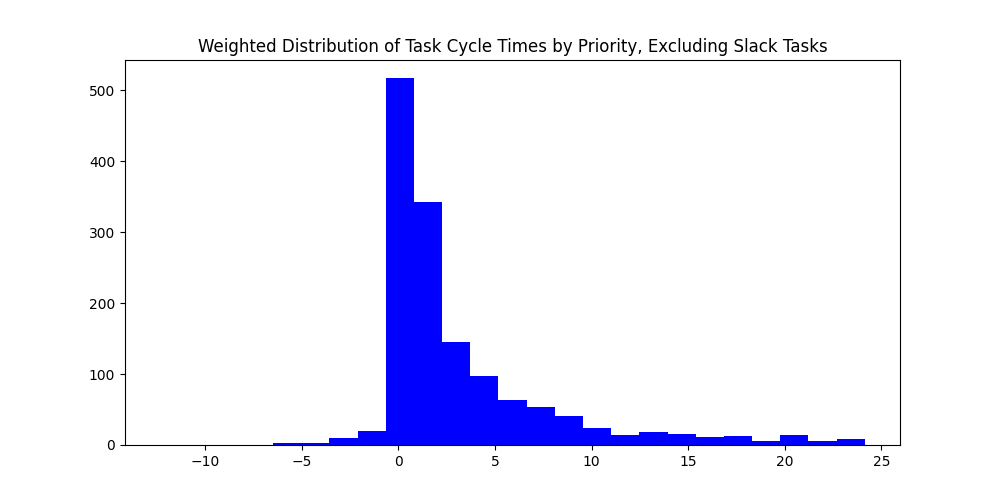

In [36]:
# CYCLE TIMES EXCLUDING TASKS MENTIONING SLACK AND WEIGHTED BY PRIORITY
tasks_no_slack = sorted([t for t in tasks if t.done and not 'slack' in t.data["doc"]["title"].lower()], key=lambda t: t.cycle_time)
cycle_times_no_slack = [t.cycle_time for t in tasks_no_slack]

q1, q3, n5, n9 = np.percentile(cycle_times_no_slack, [25, 75, 95, 99])
iqr = q3 - q1
outer_fence = q3 + 3*(iqr)

print("NOTE: Negative cycle times are recurring tasks that were marked 'done' before the date of recurrence.")

print(f"""
Q1: {q1}
Q3: {q3}
IQR: {iqr}
outer_fence: {outer_fence}
95th: {n5}
99th: {n9}
""")

# Filter Outliers
outliers = [t for t in tasks_no_slack if t.cycle_time >= outer_fence]
print(f"{len(outliers)} outliers of {len(tasks_no_slack)}: {outliers[:3]} ... {outliers[-3:]}")

tasks_no_slack_or_outliers = [t for t in tasks_no_slack if t not in outliers]
cycles_no_slack_or_outliers = [t.cycle_time for t in tasks_no_slack_or_outliers]
weights = [t.is_starred/3 for t in tasks_no_slack_or_outliers]

# Plot it
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.hist(
    cycles_no_slack_or_outliers,
    bins=math.ceil(max(cycles_no_slack_or_outliers)),
    weights=weights,
    histtype ='bar',
    facecolor='blue',
)
ax.title.set_text("Weighted Distribution of Task Cycle Times by Priority, Excluding Slack Tasks")
mplcursors.cursor(hover=True)